In [5]:
import os
import zipfile
import shutil
# Directory containing the zip files
directory = "dataset/scoop"

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".zip"):
        # Extract the base name of the zip file (remove the .zip extension)
        base_foldername = filename[:-4]
        foldername = os.path.join(directory, base_foldername)
        
        # Create a directory with the base name
        os.makedirs(foldername, exist_ok=True)
        
        # Full path of the zip file
        zip_path = os.path.join(directory, filename)
        
        # Unzip the file into the corresponding directory
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for member in zip_ref.namelist():
                # Adjust the path to avoid creating redundant subfolders
                member_path = os.path.join(foldername, os.path.basename(member))
                source = zip_ref.open(member)
                target = open(member_path, "wb")
                with source, target:
                    shutil.copyfileobj(source, target)

print("Unzipping complete.")


Unzipping complete.


In [59]:
import os
import fnmatch

directory = "dataset/sharpener"
pattern = "wrist_rgb*_1.png"  # Adjust the pattern as needed

# Loop through all folders in the directory
for foldername in sorted(os.listdir(directory)):
    folder_path = os.path.join(directory, foldername)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if fnmatch.fnmatch(filename, pattern):
                file_path = os.path.join(folder_path, filename)
                print(f"Processing file: {file_path}")
                
                # Open the image
                # with Image.open(file_path) as img:
                #     img.show()


Processing file: dataset/sharpener/t0.03_rot15/wrist_rgb_t0.03_rot15_1.png
Processing file: dataset/sharpener/t0.03_rot30/wrist_rgb_t0.03_rot30_1.png
Processing file: dataset/sharpener/t0.03_rot45/wrist_rgb_t0.03_rot45_1.png
Processing file: dataset/sharpener/t0.03_rot60/wrist_rgb_t0.03_rot60_1.png
Processing file: dataset/sharpener/t0.03_rot75/wrist_rgb_t0.03_rot75_1.png
Processing file: dataset/sharpener/t0.06_rot15/wrist_rgb_t0.06_rot15_1.png
Processing file: dataset/sharpener/t0.06_rot30/wrist_rgb_t0.06_rot30_1.png
Processing file: dataset/sharpener/t0.06_rot45/wrist_rgb_t0.06_rot45_1.png
Processing file: dataset/sharpener/t0.06_rot60/wrist_rgb_t0.06_rot60_1.png
Processing file: dataset/sharpener/t0.06_rot75/wrist_rgb_t0.06_rot75_1.png
Processing file: dataset/sharpener/t0.09_rot15/wrist_rgb_t0.09_rot15_1.png
Processing file: dataset/sharpener/t0.09_rot30/wrist_rgb_t0.09_rot30_1.png
Processing file: dataset/sharpener/t0.09_rot45/wrist_rgb_t0.09_rot45_1.png
Processing file: dataset/

dict_keys(['keypoints', 'scales', 'oris', 'descriptors', 'keypoint_scores', 'image_size'])


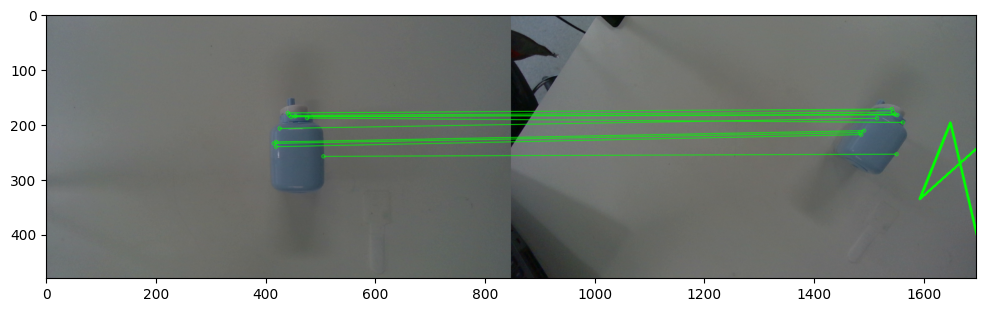

(<matplotlib.image.AxesImage at 0x2b85912d0>, None)

In [206]:
import torch
import numpy as np
import poselib
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from lightglue import LightGlue, SuperPoint, match_pair, SIFT

def numpy_image_to_torch(image: np.ndarray) -> torch.Tensor:
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float, device="cpu")

# SuperPoint+LightGlue
extractor = SuperPoint(max_num_keypoints=2048).eval().cpu()  # load the extractor
extractor = SIFT()
matcher = LightGlue(features='sift', depth_confidence=-1, width_confidence=-1).eval().cpu()  # load the matcher

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

seg = np.array(Image.open("dataset/sharpener/wrist_seg_ref.png")).astype(bool)
im1 = np.array(Image.open("dataset/sharpener/wrist_rgb_ref.png"))  # Original image
# im1 *= seg
im2 = np.array(Image.open("dataset/sharpener/t0.06_rot45/wrist_rgb_t0.06_rot45_1.png"))
feats0, feats1, matches01 = match_pair(extractor, matcher, numpy_image_to_torch(im1), numpy_image_to_torch(im2))
print(feats0.keys())
matches = matches01['matches']  # indices with shape (K,2)
mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)

coords = mkpts_0.astype(int)

# Get the segment values for the corresponding coordinates
seg_values = seg[coords[:, 1], coords[:, 0]]

# Filter points where all segment values are True
mask = np.all(seg_values, axis=1)
filtered_mkpts_0 = mkpts_0[mask]
filtered_mkpts_1 = mkpts_1[mask]

canvas = warp_corners_and_draw_matches(filtered_mkpts_0 , filtered_mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas), plt.show()

In [741]:
from scipy.spatial.transform import Rotation

K = np.load("handeye/intrinsics_d405.npy")
camera = {'model': 'PINHOLE', 'width': 848, 'height': 480, 'params': [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]}


# Normalize your points
mkpts_0_norm, T1 = normalize_points(mkpts_0, K)
mkpts_1_norm, T2 = normalize_points(mkpts_1, K)

# Use RANSAC and check different methods
E, mask = cv2.findEssentialMat(mkpts_0_norm, mkpts_1_norm, np.eye(3), method=cv2.RANSAC, prob=0.999, threshold=0.001)

# Recover pose
n, R, t, _ = cv2.recoverPose(E, mkpts_0_norm, mkpts_1_norm, np.eye(3), mask=mask)

# Scale t to match your known translation magnitude (if available)
known_translation_magnitude = 0.03  # 3cm
t_scaled = t * (known_translation_magnitude / np.linalg.norm(t))

print("Estimated translation:", t_scaled)
print("Estimated rotation (Euler angles):", Rotation.from_matrix(R).as_euler('xyz', degrees=True))

# Check essential matrix properties
U, S, Vt = np.linalg.svd(E)
print("Singular values of E:", S)

M, info = poselib.estimate_relative_pose(
    mkpts_0,
    mkpts_1,
    camera,
    camera,
    {
        "max_epipolar_error": 0.5,
    },
)
print(M, info)

def estimate_pose(kpts0, kpts1, K0, K1, thresh=0.5, conf=0.99999):
    if len(kpts0) < 5:
        return None
    
    # normalize keypoints
    kpts0 = (kpts0 - K0[[0, 1], [2, 2]][None]) / K0[[0, 1], [0, 1]][None]
    kpts1 = (kpts1 - K1[[0, 1], [2, 2]][None]) / K1[[0, 1], [0, 1]][None]

    # normalize ransac threshold
    ransac_thr = thresh / np.mean([K0[0, 0], K1[1, 1], K0[0, 0], K1[1, 1]])

    # compute pose with cv2
    E, mask = cv2.findEssentialMat(
        kpts0, kpts1, np.eye(3), threshold=ransac_thr, prob=conf, method=cv2.RANSAC)
    if E is None:
        print("\nE is None while trying to recover pose.\n")
        return None

    # recover pose from E
    best_num_inliers = 0
    ret = None
    for _E in np.split(E, len(E) / 3):
        n, R, t, _ = cv2.recoverPose(_E, kpts0, kpts1, np.eye(3), 1e9, mask=mask)
        if n > best_num_inliers:
            ret = (R, t[:, 0], mask.ravel() > 0)
            best_num_inliers = n

    return ret

ret = estimate_pose(mkpts_0, mkpts_1, K, K)
print(ret[1] * 0.03, Rotation.from_matrix(ret[0]).as_euler('xyz', degrees=True))


Estimated translation: [[0.022057  ]
 [0.01496405]
 [0.0137683 ]]
Estimated rotation (Euler angles): [33.85866735 -9.29483817 -8.73401465]
Singular values of E: [7.07106781e-01 7.07106781e-01 5.51681756e-16]
[q:    0.681691    0.294987   -0.669529 -0.00313762, t: 0.778668 0.291205 0.555766] {'refinements': 9, 'iterations': 1001, 'num_inliers': 8, 'inlier_ratio': 0.5333333333333333, 'model_score': 1.0196570147296537e-05, 'inliers': [False, False, False, False, True, False, False, True, True, True, False, True, True, True, True]}
[0.01943074 0.01146674 0.01977272] [-6.22059049 39.58518639  3.23173808]


In [362]:
def normalize_mkpts(mkpts, K):
    """
    Normalize image points using the camera intrinsic matrix.

    Args:
    mkpts: Nx2 numpy array of image points.
    K: 3x3 intrinsic matrix.

    Returns:
    normalized_points: Nx3 numpy array of normalized points in homogeneous coordinates.
    """
    # Convert points to homogeneous coordinates
    mkpts_h = np.hstack((mkpts, np.ones((mkpts.shape[0], 1))))

    # Compute the inverse of the intrinsic matrix
    K_inv = np.linalg.inv(K)

    # Normalize points
    normalized_points = (K_inv @ mkpts_h.T).T

    return normalized_points

normalize_points(mkpts_0, K)

array([[ 0.08304608, -0.16488598,  1.        ],
       [ 0.10415385, -0.16488598,  1.        ],
       [ 0.0465872 , -0.15911803,  1.        ],
       [ 0.1271805 , -0.15911803,  1.        ],
       [ 0.01972277, -0.1418143 ,  1.        ],
       [ 0.13677494, -0.12835585,  1.        ],
       [ 0.05042498, -0.12643318,  1.        ],
       [ 0.08880274, -0.12643318,  1.        ],
       [ 0.01588499, -0.11489736,  1.        ],
       [ 0.15596382, -0.11489736,  1.        ],
       [ 0.05618164, -0.10912945,  1.        ],
       [ 0.07345164, -0.09182571,  1.        ],
       [ 0.15788271, -0.08990305,  1.        ],
       [ 0.01588499, -0.0860578 ,  1.        ],
       [ 0.19050381, -0.07067668,  1.        ],
       [ 0.11374829, -0.06298611,  1.        ],
       [ 0.05042498, -0.06106348,  1.        ],
       [ 0.19626047, -0.06106348,  1.        ],
       [-0.0167361 , -0.0572182 ,  1.        ],
       [ 0.01780388, -0.05529557,  1.        ],
       [-0.02057388, -0.047605  ,  1.   

In [464]:
index_t = 0.03
index_r = 15
depth = np.copy(Image.open(f"dataset/sharpener/wrist_depth_ref.png"))
points_3ds = []
normalized_mkpt_0 = normalize_mkpts(mkpts_0, K)
for (i, mkpt_0) in enumerate(mkpts_0):
    x = int(mkpt_0[0])
    y = int(mkpt_0[1])
    points_3d = normalized_mkpt_0[i] * depth[y, x] / 1000
    points_3ds.append(points_3d)

M_essential, _ = poselib.estimate_relative_pose(mkpts_0, mkpts_1, camera, camera, {"method": "relpose_5pt"})
M_homography, _ = poselib.estimate_relative_pose(mkpts_0, mkpts_1, camera, camera, {"method": "HOMOGRAPHY"})

M_essential, M_homography

([q: 0.969602 0.128604 0.175352 0.112179, t:   0.236787 -0.0495859   0.970409],
 [q: 0.969602 0.128604 0.175352 0.112179, t:   0.236787 -0.0495859   0.970409])

In [370]:
def select_best_decomposition(decompositions):
    Rs, ts, normals = decompositions[1], decompositions[2], decompositions[3]
    best_index = -1
    best_score = float('inf')

    for i, (R, t, n) in enumerate(zip(Rs, ts, normals)):
        # # Heuristic 1: Check the magnitude of the translation vector (consider all components)
        # translation_magnitude = np.linalg.norm(t)

        # # Heuristic 2: Ensure the normal is close to [0, 0, 1]
        # normal_deviation = np.linalg.norm(n - np.array([0, 0, 1]))

        # Heuristic 3: Check the rotation matrix (for dominant yaw)
        yaw = np.arctan2(R[1, 0], R[0, 0])
        pitch = np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2))
        roll = np.arctan2(R[2, 1], R[2, 2])

        # Ideally, pitch and roll should be small in a top-down view
        rotation_score = np.abs(pitch) + np.abs(roll)

        # Combine heuristics into a single score
        score = rotation_score

        if score < best_score:
            best_score = score
            best_index = i

    if best_index != -1:
        best_R = Rs[best_index]
        best_t = ts[best_index]
        best_normal = normals[best_index]
    else:
        print("No valid decomposition found.")

    return Rotation.from_matrix(best_R).as_euler('xyz', degrees=True), best_t


H, mask = cv2.findHomography(mkpts_0_norm, mkpts_1_norm, cv2.USAC_MAGSAC, 0.001)
H = np.linalg.inv(T2) @ H @ T1
decompositions = cv2.decomposeHomographyMat(H, np.eye(3))
best_R, best_t = select_best_decomposition(decompositions)
best_R, best_t

H - H.T

array([[ 0.        , -0.78238085,  0.55525433],
       [ 0.78238085,  0.        ,  0.12589361],
       [-0.55525433, -0.12589361,  0.        ]])

In [184]:
# Compute the determinant of H
det_H = np.linalg.det(H)
# Compute the ratio Z/Z*
# Note: Z/Z* = (det(H))^(-1/3)
Z_ratio = det_H ** (-1/3)
# Compute the error using natural logarithm
e_z = np.log(Z_ratio)
e_z

0.040103037341307726

In [180]:
import json
with open(f"experiments/pencile_sharpener/demo_bottlenecks.json") as f:
    dbn = json.load(f)


m = np.array(dbn['bottleneck_left'][:3])
m / m[2]
H

array([[ 0.75898534, -0.51092769,  0.36099819],
       [ 0.48008521,  0.76128805, -0.0968049 ],
       [-0.28509641, -0.09779719,  1.02847237]])

In [144]:
print(M.t * 0.03, Rotation.from_quat(quat).as_euler('xyz', degrees=True))

[-0.00769267 -0.01221167  0.02630015] [17.81946491 40.95855356 39.67719762]


In [429]:
def add_depth(mkpts, depth):
    points_3ds = []
    normalized_mkpts = normalize_mkpts(mkpts, K)
    for (i, mkpt) in enumerate(mkpts):
        x = int(mkpt[0])
        y = int(mkpt[1])
        points_3d = normalized_mkpts[i] * depth[y, x] / 1000
        points_3ds.append(points_3d)
    return np.array(points_3ds)


def find_transformation(X, Y):
    # Find transformation given two sets of correspondences between 3D points
    # Calculate centroids
    non_zero_indices = np.all(X != [0, 0, 0], axis=1) & np.all(Y != [0, 0, 0], axis=1)
    X = X[non_zero_indices]
    Y = Y[non_zero_indices]
    cX = np.mean(X, axis=0)
    cY = np.mean(Y, axis=0)
    # Subtract centroids to obtain centered sets of points
    Xc = X - cX
    Yc = Y - cY
    # Calculate covariance matrix
    C = np.dot(Xc.T, Yc)
    # Compute SVD
    U, S, Vt = np.linalg.svd(C)
    # Determine rotation matrix
    R = np.dot(Vt.T, U.T)
    # Determine translation vector
    t = cY - np.dot(R, cX)

    return R, t

def compute_rigid_transform(P, Q):
    """
    Compute the rigid transformation (R, t) that aligns two sets of 3D points.
    
    Args:
    P: Nx3 numpy array of 3D points in the source coordinate frame.
    Q: Nx3 numpy array of 3D points in the destination coordinate frame.
    
    Returns:
    R: 3x3 rotation matrix.
    t: 3x1 translation vector.
    """
    assert P.shape == Q.shape, "P and Q must have the same shape"
    non_zero_indices = np.all(P != [0, 0, 0], axis=1) & np.all(Q != [0, 0, 0], axis=1)
    P = P[non_zero_indices]
    Q = Q[non_zero_indices]

    # Number of points
    N = P.shape[0]
    
    # Compute centroids
    c_P = np.mean(P, axis=0)
    c_Q = np.mean(Q, axis=0)
    
    # Centralize points
    P_prime = P - c_P
    Q_prime = Q - c_Q
    
    # Compute covariance matrix
    H = P_prime.T @ Q_prime
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(H)
    
    # Compute rotation matrix
    R = Vt.T @ U.T
    
    # Special reflection case
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = Vt.T @ U.T
    
    # Compute translation vector
    t = c_Q - R @ c_P
    
    return R, t

array([[[ 0.08304608, -0.09182571]]], dtype=float32)

In [648]:
from scipy.spatial.transform import Rotation
from tqdm import tqdm

seg = np.array(Image.open("dataset/sharpener/wrist_seg_ref.png")).astype(bool)
im1 = np.array(Image.open("dataset/sharpener/wrist_rgb_ref.png")) # Original image
# im1 *= seg
# xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = True, top_k = 2048)
K = np.load("handeye/intrinsics_d405.npy")

camera = {'model': 'PINHOLE', 'width': 848, 'height': 480, 'params': [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]}

t = []
R = []
t_cv = []
R_cv = []
t_ho = []
R_ho = []
t_3d = []
R_3d = []
t_3d_2 = []
R_3d_2 = []
index_t = 0.03
index_r = 15
for i in tqdm(range(20), desc="Processing"):
    im2 = np.copy(Image.open(f"dataset/sharpener/t{index_t}_rot{index_r}/wrist_rgb_t{index_t}_rot{index_r}_{i+1}.png"))
    feats0, feats1, matches01 = match_pair(extractor, matcher, numpy_image_to_torch(im1), numpy_image_to_torch(im2))
    matches = matches01['matches']  # indices with shape (K,2)
    mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
    mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)
    M, info = poselib.estimate_relative_pose(
        mkpts_0,
        mkpts_1,
        camera,
        camera,
        {
            "max_epipolar_error": 0.5,
        },
    )
    print(M)
    t.append(M.t)
    quat = np.append(M.q[1:], M.q[0])
    R.append(Rotation.from_quat(quat).as_euler('xyz', degrees=True))

    mkpts_0_norm, T1 = normalize_points(mkpts_0, K)
    mkpts_1_norm, T2 = normalize_points(mkpts_1, K)

    # Use RANSAC and check different methods
    E, mask = cv2.findEssentialMat(mkpts_0_norm, mkpts_1_norm, np.eye(3), method=cv2.RANSAC, prob=0.999, threshold=0.001)

    # Recover pose
    n, rotation, translation, _ = cv2.recoverPose(E, mkpts_0_norm, mkpts_1_norm, np.eye(3), mask=mask)
    R_cv.append(Rotation.from_matrix(rotation).as_euler('xyz', degrees=True))
    t_cv.append(translation)

    H, mask = cv2.findHomography(mkpts_0_norm, mkpts_1_norm, cv2.USAC_MAGSAC, 0.001)
    H = np.linalg.inv(T2) @ H @ T1
    decompositions = cv2.decomposeHomographyMat(H, np.eye(3))
    best_R, best_t = select_best_decomposition(decompositions)

    R_ho.append(best_R)
    t_ho.append(best_t)

    depth1 = np.copy(Image.open(f"dataset/sharpener/wrist_depth_ref.png"))
    depth2 = np.copy(Image.open(f"dataset/sharpener/t{index_t}_rot{index_r}/wrist_depth_t{index_t}_rot{index_r}_{i+1}.png"))
    points1_3d = add_depth(mkpts_0, depth1)
    points2_3d = add_depth(mkpts_1, depth2)
    delta_R_camera, delta_t_camera = find_transformation(points1_3d, points2_3d)
    t_3d.append(delta_t_camera)
    R_3d.append(Rotation.from_matrix(delta_R_camera).as_euler('xyz', degrees=True))


Processing:   5%|▌         | 1/20 [00:04<01:34,  4.98s/it]

[q:    0.991581   0.0157925 0.000718895    0.128522, t:  0.879317 -0.323449  0.349841]


Processing:  10%|█         | 2/20 [00:08<01:12,  4.03s/it]

[q:  0.979249 0.0599959  0.161291   0.10704, t: -0.156671 -0.201196  0.967104]


Processing:  15%|█▌        | 3/20 [00:11<01:03,  3.72s/it]

[q:  0.918631 0.0911528  0.361897  0.129761, t: -0.660072 -0.113353  0.742622]


Processing:  20%|██        | 4/20 [00:15<00:57,  3.60s/it]

[q:  0.993934 0.0403504 0.0311519 0.0974462, t:   0.84327 -0.201096  0.499064]


Processing:  25%|██▌       | 5/20 [00:19<00:56,  3.80s/it]

[q:    0.992369    0.019239 -0.00149583    0.121785, t:  0.898957 -0.307191  0.312355]


Processing:  30%|███       | 6/20 [00:23<00:53,  3.81s/it]

[q:   0.993202  0.0168343 0.00751441    0.11493, t:  0.866893 -0.329954  0.373691]


Processing:  35%|███▌      | 7/20 [00:26<00:48,  3.76s/it]

[q:   0.991045  0.0146661 -0.0047271   0.132636, t:  0.89226 -0.31965 0.318999]


Processing:  40%|████      | 8/20 [00:30<00:43,  3.63s/it]

[q:    0.993555 6.61284e-05  -0.0154802     0.11229, t:    0.8823 -0.361962  0.300966]


Processing:  45%|████▌     | 9/20 [00:33<00:38,  3.53s/it]

[q:    0.993119 -0.00295448  -0.0235458    0.114676, t:  0.890564 -0.359871  0.278306]


Processing:  50%|█████     | 10/20 [00:36<00:34,  3.48s/it]

[q:  0.989953 0.0608144 0.0660998    0.1092, t:   0.53423 -0.154522  0.831109]


Processing:  55%|█████▌    | 11/20 [00:40<00:32,  3.63s/it]

[q:  0.890128 -0.193266  0.376748  0.168466, t: -0.287158 -0.661174  0.693138]


Processing:  60%|██████    | 12/20 [00:44<00:28,  3.61s/it]

[q:   0.992045  0.0245931 0.00288432   0.123422, t:  0.902876 -0.290023  0.317533]


Processing:  65%|██████▌   | 13/20 [00:47<00:24,  3.55s/it]

[q:    0.9924 0.0214086 0.0105718  0.120713, t:  0.861405 -0.300977  0.409381]


Processing:  70%|███████   | 14/20 [00:51<00:20,  3.49s/it]

[q:     0.9916  0.0155492 0.00333487   0.128363, t:  0.867817 -0.319437  0.380742]


Processing:  75%|███████▌  | 15/20 [00:54<00:17,  3.46s/it]

[q:  0.991054 0.0345441   0.04646  0.120254, t:  0.708353 -0.306565  0.635933]


Processing:  80%|████████  | 16/20 [00:57<00:13,  3.43s/it]

[q:   0.990142  0.0129504 -0.0164853   0.138491, t:  0.918942 -0.317485  0.234206]


Processing:  85%|████████▌ | 17/20 [01:01<00:10,  3.43s/it]

[q:   0.988502 0.00844461 -0.0318044   0.147582, t:    0.9321 -0.310517  0.187037]


Processing:  90%|█████████ | 18/20 [01:04<00:06,  3.39s/it]

[q:   0.991963 -0.0323563 -0.0257975   0.119572, t:  0.835295 -0.469038  0.287332]


Processing:  95%|█████████▌| 19/20 [01:08<00:03,  3.59s/it]

[q:   0.991804  0.0197184 0.00576174   0.126106, t:  0.876313 -0.310296  0.368575]


Processing: 100%|██████████| 20/20 [01:11<00:00,  3.60s/it]

[q:   0.99587 0.0258113 0.0235351 0.0838017, t:  0.826418 -0.264433  0.497128]


In [649]:
R = np.array(R)
t = np.array(t)

np.mean(R, axis=0), np.mean(t, axis=0), np.std(R, axis=0), np.std(t, axis=0)

(array([ 2.24054762,  5.49848543, 14.29334915]),
 array([ 0.66567031, -0.31110936,  0.44925311]),
 array([ 6.72024444, 13.53321934,  2.56244688]),
 array([0.45007347, 0.11038895, 0.20892906]))

In [650]:
R_cv = np.array(R_cv)
t_cv = np.array(t_cv)

np.mean(R_cv, axis=0), np.mean(t_cv, axis=0), np.std(R_cv, axis=0), np.std(t_cv, axis=0)

(array([ 1.65872474,  4.45483465, 15.70584531]),
 array([[-0.15035674],
        [-0.23839171],
        [ 0.08959961]]),
 array([2.84594531, 5.47666534, 4.04424433]),
 array([[0.79171309],
        [0.37751751],
        [0.37842446]]))

In [651]:
R_ho = np.array(R_ho)
t_ho = np.array(t_ho)

np.mean(R_ho, axis=0), np.mean(t_ho, axis=0), np.std(R_ho, axis=0), np.std(t_ho, axis=0)

(array([ 1.35632722, -0.53745362, 15.0408115 ]),
 array([[ 0.33637728],
        [-0.08415039],
        [ 0.13852223]]),
 array([4.98433325, 3.88930673, 2.78522982]),
 array([[0.0400752 ],
        [0.11668488],
        [0.0682523 ]]))

In [652]:
R_3d = np.array(R_3d)
t_3d = np.array(t_3d)

np.mean(R_3d, axis=0), np.mean(t_3d, axis=0), np.std(R_3d, axis=0), np.std(t_3d, axis=0)

(array([ 3.07760528,  0.92519802, 14.99631548]),
 array([ 0.05197495, -0.01774564,  0.02443353]),
 array([1.45576665, 0.72588222, 0.28170629]),
 array([0.00428726, 0.00491433, 0.00107773]))

In [653]:
R_3d_2 = np.array(R_3d_2)
t_3d_2 = np.array(t_3d_2)

np.mean(R_3d_2, axis=0), np.mean(t_3d_2, axis=0), np.std(R_3d_2, axis=0), np.std(t_3d_2, axis=0)

(array([ 3.07760528,  0.92519802, 14.99631548]),
 array([ 0.05197495, -0.01774564,  0.02443353]),
 array([1.45576665, 0.72588222, 0.28170629]),
 array([0.00428726, 0.00491433, 0.00107773]))

In [654]:
from trajectory_utils import create_homogeneous_matrix, euler_from_matrix
from trajectory_utils import pose_inv

d405_T_C_EEF = np.load("handeye/T_C_EEF_wrist_l.npy")
# Desired world frame translation
d405_T_C_EEF[:3, 3] = np.zeros(3)
world_translation = np.array([0.03, 0.03, 0.03])

# Rotation: 30 degrees around Z-axis
rotation = Rotation.from_euler('xyz', [0, 0, 15], degrees=True)

# Compute the required end-effector translation
# This is done by applying the inverse rotation to the world translation
eef_translation = rotation.inv().apply(world_translation)

print(eef_translation)
# Now create the correct T_delta_eef
T_delta_eef = np.eye(4)
T_delta_eef[:3, :3] = rotation.as_matrix()
T_delta_eef[:3, 3] = eef_translation

T_delta_cam = d405_T_C_EEF @ T_delta_eef @ pose_inv(d405_T_C_EEF)
np.degrees(euler_from_matrix(T_delta_cam)), T_delta_cam[:3, 3]
# T_new_eef_world = T_eef_world @ self.T_camera_eef @ delta_camera @ pose_inv(self.T_camera_eef)


[0.03674235 0.0212132  0.03      ]


(array([-8.11502389e-03,  9.63090808e-01,  1.49691560e+01]),
 array([-0.03763066, -0.01816458,  0.03088659]))

In [655]:
import numpy as np

def angular_error(R_gt, R_est):
    # Compute the relative rotation matrix
    R_rel = np.dot(R_gt.T, R_est)
    
    # Compute the trace of the relative rotation matrix
    trace_R_rel = np.trace(R_rel)
    
    # Compute the angle of rotation
    theta = np.arccos((trace_R_rel - 1) / 2)
    
    # Convert radians to degrees if needed
    theta_deg = np.degrees(theta)
    
    return theta_deg

# Example rotation matrices (replace these with your actual matrices)
R_gt = T_delta_cam[:3, :3]

errors = []
for r in R_ho:
    R_est = Rotation.from_euler('xyz', r, degrees=True).as_matrix()
    # Compute the angular error
    error = angular_error(R_gt, R_est)
    errors.append(error)

errors = np.array(errors)
print("homography:", np.mean(errors), np.std(errors))

errors = []
for r in R:
    R_est = Rotation.from_euler('xyz', r, degrees=True).as_matrix()
    # Compute the angular error
    error = angular_error(R_gt, R_est)
    errors.append(error)

errors = np.array(errors)
print("essential 1:", np.mean(errors), np.std(errors))

errors = []
for r in R_cv:
    R_est = Rotation.from_euler('xyz', r, degrees=True).as_matrix()
    # Compute the angular error
    error = angular_error(R_gt, R_est)
    errors.append(error)

errors = np.array(errors)
print("essential 2:", np.mean(errors), np.std(errors))

errors = []
for r in R_3d:
    R_est = Rotation.from_euler('xyz', r, degrees=True).as_matrix()
    # Compute the angular error
    error = angular_error(R_gt, R_est)
    errors.append(error)

errors = np.array(errors)
print("3d:", np.mean(errors), np.std(errors))

errors = []
for r in R_3d_2:
    R_est = Rotation.from_euler('xyz', r, degrees=True).as_matrix()
    # Compute the angular error
    error = angular_error(R_gt, R_est)
    errors.append(error)

errors = np.array(errors)
print("3d2:", np.mean(errors), np.std(errors))

homography: 6.192018461480001 3.7420036538193404
essential 1: 9.135283833353935 12.984833946790548
essential 2: 6.9730554327819565 4.445695197458068
3d: 3.218551488158378 1.3662150408965388
3d2: 3.218551488158378 1.3662150408965388


In [659]:
def compute_translation_error(t_gt, t_est):
    """
    Compute the angular error between the ground truth and estimated translation vectors.
    """
    t_gt_norm = t_gt / np.linalg.norm(t_gt)
    t_est_norm = t_est / np.linalg.norm(t_est)
    cos_theta = np.dot(t_gt_norm, t_est_norm)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)  # Ensure value is within valid range
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

def compute_normalized_distance_error(t_gt, t_est):
    """
    Compute the normalized distance error between ground truth and estimated translation vectors.
    
    Parameters:
    t_gt (numpy.ndarray): Ground truth translation vector
    t_est (numpy.ndarray): Estimated translation vector
    
    Returns:
    float: Normalized distance error
    """
    t_gt_normalized = t_gt / np.linalg.norm(t_gt)
    t_est_normalized = t_est / np.linalg.norm(t_est)
    print(t_gt_normalized, t_est_normalized)
    error = np.linalg.norm(t_gt_normalized - t_est_normalized)
    
    return error

t_gt = T_delta_cam[:3, 3]
t_gt = eef_translation @ np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])
errors = []
for t_est in t_ho:
    # Compute the angular error
    errors.append(compute_translation_error(t_gt, t_est))

errors = np.array(errors)
print("homography:", np.mean(errors), np.std(errors))

errors = []
for t_est in t:
    # Compute the angular error
    errors.append(compute_translation_error(t_gt, t_est))

errors = np.array(errors)
print("essential 1:", np.mean(errors), np.std(errors))

errors = []
for t_est in t_cv:
    # Compute the angular error
    errors.append(compute_translation_error(t_gt, t_est))

errors = np.array(errors)
print("essential 2:", np.mean(errors), np.std(errors))

errors = []
for t_est in t_3d:
    # Compute the angular error
    errors.append(compute_translation_error(t_gt, t_est))

errors = np.array(errors)
print("3d:", np.mean(errors), np.std(errors))

errors = []
for t_est in t_3d_2:
    # Compute the angular error
    errors.append(compute_translation_error(t_gt, t_est))

errors = np.array(errors)
print("3d2:", np.mean(errors), np.std(errors))

homography: 24.374189922769347 10.317991658874716
essential 1: 25.61004254931283 19.827140866395737
essential 2: 85.64973767092184 41.9766512202983
3d: 15.298321475580256 1.764969910783255
3d2: 15.298321475580256 1.764969910783255


In [225]:
[t / np.linalg.norm(t) for t in t_ho]

[array([[ 0.3039499 ],
        [-0.11811553],
        [ 0.9453376 ]]),
 array([[ 0.44894904],
        [-0.83365581],
        [ 0.32165626]]),
 array([[ 0.51308742],
        [-0.79908172],
        [ 0.31338427]]),
 array([[0.36746367],
        [0.0176596 ],
        [0.9298702 ]]),
 array([[ 0.63440827],
        [-0.72494055],
        [ 0.26830456]]),
 array([[ 0.7698315 ],
        [-0.58106761],
        [ 0.26404527]]),
 array([[0.34677631],
        [0.06822898],
        [0.93546299]]),
 array([[0.27630643],
        [0.11902025],
        [0.9536713 ]]),
 array([[ 0.78140833],
        [-0.59824548],
        [ 0.17749186]]),
 array([[0.35569664],
        [0.09552303],
        [0.92970708]]),
 array([[0.3406459 ],
        [0.04873997],
        [0.93892747]]),
 array([[0.3223403],
        [0.0178101],
        [0.9464563]]),
 array([[-0.36011759],
        [-0.03802164],
        [-0.93213179]]),
 array([[ 0.8281577 ],
        [-0.5311549 ],
        [ 0.17896731]]),
 array([[ 0.78717635],
    

In [208]:
R_ho.shape[0]

50

In [205]:
import pickle

# Save the dictionary to a pickle file
with open("dataset/sharpener/lg_Essential.pkl", "wb") as file:
    pickle.dump(lg_Essential, file)

In [210]:
# Load the dictionary from the pickle file
with open("dataset/sharpener/lg_Essential.pkl", "rb") as file:
    lg_Essential_loaded = pickle.load(file)

# Accessing the loaded data
R_loaded = lg_Essential_loaded["0, 0"]["R"]
t_loaded = lg_Essential_loaded["0, 0"]["t"]

print("Loaded Rotation Matrix R:\n", R_loaded)
print("Loaded Translation Vector t:\n", t_loaded)

Loaded Rotation Matrix R:
 [[9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e-15 0.00000000e+00 1.68781047e-15]
 [9.87850249e

In [349]:
torch.backends.mps.is_available()

True

In [1]:
from mini_dust3r.api import OptimizedResult, inferece_dust3r, log_optimized_result
from mini_dust3r.model import AsymmetricCroCo3DStereo
import torch
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = AsymmetricCroCo3DStereo.from_pretrained(
    "nielsr/DUSt3R_ViTLarge_BaseDecoder_512_dpt"
).to(device)


def main(image_dir):

    optimized_results: OptimizedResult = inferece_dust3r(
        image_dir_or_list=image_dir,
        model=model,
        device=device,
        batch_size=1,
    )

    return optimized_results

Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead
0.23.4


In [6]:
import numpy as np
from scipy.spatial.transform import Rotation
from tqdm import tqdm
import pandas as pd
from trajectory_utils import pose_inv

def angular_error(R_gt, R_est):
    # Compute the relative rotation matrix
    R_rel = np.dot(R_gt.T, R_est)
    trace_R_rel = np.trace(R_rel)
    theta = np.arccos((trace_R_rel - 1) / 2)
    theta_deg = np.degrees(theta)
    
    return theta_deg

# Translations and rotations to test
translations = [0.03, 0.06, 0.09, 0.12, 0.15]
rotations = [15, 30, 45, 60, 75]

# Initialize error lists
all_errors_translation = []
all_errors_rotation = []

for i, t in enumerate(tqdm(translations, desc="Processing Translations", leave=False)):
    for j, r in enumerate(tqdm(rotations, desc=f"Processing Rotation for t={t}", leave=False)):
        errors_translation = []
        errors_rotation = []
        for k in range(2):
            res = main(["dataset/sharpener/wrist_rgb_ref.png", f"dataset/sharpener/t{t}_rot{r}/wrist_rgb_t{t}_rot{r}_{k+1}.png"])

            T_0, T_1 = res.world_T_cam_b44[0], res.world_T_cam_b44[1]
            if np.allclose(T_1, np.eye(4)):
                T = T_0
            else:
                T = pose_inv(T_1)
            
            # Ground truth translation vector
            world_translation = np.array([t, t, t])
            rotation = Rotation.from_euler('xyz', [0, 0, r], degrees=True)
            eef_translation = rotation.inv().apply(world_translation)
            t_gt = eef_translation @ np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])
            
            gt_T = np.eye(4)
            gt_T[:3, :3] = rotation.as_matrix()
            gt_T[:3, 3] = t_gt
            
            delta_T = gt_T @ pose_inv(T)
        
            # Compute translation and rotation errors
            translation_error = np.linalg.norm(delta_T[:3, 3])
            errors_translation.append(translation_error)
            
            rotation_error_value = angular_error(gt_T[:3, :3], T[:3, :3])
            errors_rotation.append(rotation_error_value)
        
        all_errors_translation.append((t, r, np.mean(errors_translation), np.std(errors_translation)))
        all_errors_rotation.append((t, r, np.mean(errors_rotation), np.std(errors_rotation)))

# Create dataframes for better readability
df_translation = pd.DataFrame(all_errors_translation, columns=['Translation', 'Rotation', 'Mean Translation Error', 'STD Translation Error'])
df_rotation = pd.DataFrame(all_errors_rotation, columns=['Translation', 'Rotation', 'Mean Rotation Error', 'STD Rotation Error'])

print("Translation Errors:")
print(df_translation.to_string(index=False))

print("\nRotation Errors:")
print(df_rotation.to_string(index=False))


Processing Translations:   0%|          | 0/5 [00:00<?, ?it/s]

>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot15/wrist_rgb_t0.03_rot15_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


  - conf=3.18 for edge 0-1
  - conf=3.9 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 36.25it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot15/wrist_rgb_t0.03_rot15_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=3.92 for edge 0-1
  - conf=2.55 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 37.06it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot30/wrist_rgb_t0.03_rot30_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


  - conf=5.22 for edge 0-1
  - conf=5.54 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 34.42it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot30/wrist_rgb_t0.03_rot30_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


  - conf=4.84 for edge 0-1
  - conf=4.32 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 34.01it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot45/wrist_rgb_t0.03_rot45_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


  - conf=5.6 for edge 0-1
  - conf=4.33 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 30.13it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot45/wrist_rgb_t0.03_rot45_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


  - conf=5.02 for edge 0-1
  - conf=4.04 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 37.18it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot60/wrist_rgb_t0.03_rot60_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


  - conf=8.21 for edge 0-1
  - conf=8.76 for edge 1-0




100%|██████████| 2/2 [00:00<00:00, 18.59it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot60/wrist_rgb_t0.03_rot60_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


  - conf=8.46 for edge 0-1
  - conf=6.86 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 33.93it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot75/wrist_rgb_t0.03_rot75_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=10.9 for edge 0-1
  - conf=11.6 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 31.29it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.03_rot75/wrist_rgb_t0.03_rot75_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


  - conf=10.5 for edge 0-1
  - conf=11.8 for edge 1-0



Processing Translations:  20%|██        | 1/5 [00:27<01:49, 27.44s/it]

>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot15/wrist_rgb_t0.06_rot15_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


  - conf=5.03 for edge 0-1
  - conf=6.82 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 26.05it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot15/wrist_rgb_t0.06_rot15_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


  - conf=7.14 for edge 0-1
  - conf=14.2 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 28.73it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot30/wrist_rgb_t0.06_rot30_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


  - conf=4.68 for edge 0-1
  - conf=5.31 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 34.79it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot30/wrist_rgb_t0.06_rot30_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=4.42 for edge 0-1
  - conf=5.61 for edge 1-0




100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot45/wrist_rgb_t0.06_rot45_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


  - conf=3.28 for edge 0-1
  - conf=5.82 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 35.97it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot45/wrist_rgb_t0.06_rot45_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


  - conf=2.39 for edge 0-1
  - conf=2.13 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 43.18it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot60/wrist_rgb_t0.06_rot60_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


  - conf=3.44 for edge 0-1
  - conf=2.54 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 38.48it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot60/wrist_rgb_t0.06_rot60_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


  - conf=4.68 for edge 0-1
  - conf=5.24 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 36.73it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot75/wrist_rgb_t0.06_rot75_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


  - conf=6.41 for edge 0-1
  - conf=5.71 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 35.65it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.06_rot75/wrist_rgb_t0.06_rot75_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=7.43 for edge 0-1
  - conf=11.6 for edge 1-0



Processing Translations:  40%|████      | 2/5 [00:54<01:21, 27.20s/it]

>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot15/wrist_rgb_t0.09_rot15_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


  - conf=4.01 for edge 0-1
  - conf=4.83 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 36.44it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot15/wrist_rgb_t0.09_rot15_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


  - conf=4.23 for edge 0-1
  - conf=6.94 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 36.53it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot30/wrist_rgb_t0.09_rot30_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=3.1 for edge 0-1
  - conf=2.92 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 42.32it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot30/wrist_rgb_t0.09_rot30_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=2.47 for edge 0-1
  - conf=3.37 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 44.02it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot45/wrist_rgb_t0.09_rot45_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


  - conf=2.57 for edge 0-1
  - conf=3.66 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 41.92it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot45/wrist_rgb_t0.09_rot45_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


  - conf=2.12 for edge 0-1
  - conf=3.41 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 42.36it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot60/wrist_rgb_t0.09_rot60_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


  - conf=3.47 for edge 0-1
  - conf=3.25 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 37.22it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot60/wrist_rgb_t0.09_rot60_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


  - conf=4.45 for edge 0-1
  - conf=2.56 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 37.55it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot75/wrist_rgb_t0.09_rot75_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


  - conf=8.34 for edge 0-1
  - conf=8.76 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 28.32it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.09_rot75/wrist_rgb_t0.09_rot75_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


  - conf=7.51 for edge 0-1
  - conf=8.85 for edge 1-0



Processing Translations:  60%|██████    | 3/5 [01:20<00:53, 26.72s/it]

>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot15/wrist_rgb_t0.12_rot15_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=7.52 for edge 0-1
  - conf=9.21 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 29.91it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot15/wrist_rgb_t0.12_rot15_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


  - conf=6.6 for edge 0-1
  - conf=7.12 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 30.07it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot30/wrist_rgb_t0.12_rot30_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


  - conf=9.02 for edge 0-1
  - conf=10.2 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 28.88it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot30/wrist_rgb_t0.12_rot30_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


  - conf=8.85 for edge 0-1
  - conf=10.6 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 29.75it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot45/wrist_rgb_t0.12_rot45_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


  - conf=7.49 for edge 0-1
  - conf=5.75 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 31.23it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot45/wrist_rgb_t0.12_rot45_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


  - conf=6.3 for edge 0-1
  - conf=5.76 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 31.40it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot60/wrist_rgb_t0.12_rot60_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


  - conf=6.64 for edge 0-1
  - conf=6.91 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 33.38it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot60/wrist_rgb_t0.12_rot60_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


  - conf=4.94 for edge 0-1
  - conf=5.4 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 29.96it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot75/wrist_rgb_t0.12_rot75_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


  - conf=5.07 for edge 0-1
  - conf=5.78 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 31.66it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.12_rot75/wrist_rgb_t0.12_rot75_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


  - conf=2.09 for edge 0-1
  - conf=4.9 for edge 1-0



Processing Translations:  80%|████████  | 4/5 [01:48<00:27, 27.13s/it]

>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot15/wrist_rgb_t0.15_rot15_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


  - conf=6.91 for edge 0-1
  - conf=6.13 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 29.06it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot15/wrist_rgb_t0.15_rot15_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


  - conf=9.1 for edge 0-1
  - conf=10.8 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 28.31it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot30/wrist_rgb_t0.15_rot30_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


  - conf=9.1 for edge 0-1
  - conf=10.6 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 28.02it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot30/wrist_rgb_t0.15_rot30_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


  - conf=9.51 for edge 0-1
  - conf=10.6 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 29.06it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot45/wrist_rgb_t0.15_rot45_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


  - conf=8.81 for edge 0-1
  - conf=9.04 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 25.15it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot45/wrist_rgb_t0.15_rot45_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


  - conf=6.14 for edge 0-1
  - conf=5.42 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 31.81it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot60/wrist_rgb_t0.15_rot60_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


  - conf=2.82 for edge 0-1
  - conf=1.84 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 39.87it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot60/wrist_rgb_t0.15_rot60_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


  - conf=2.57 for edge 0-1
  - conf=3.03 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 35.26it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot75/wrist_rgb_t0.15_rot75_1.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


  - conf=4.61 for edge 0-1
  - conf=4.23 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 31.02it/s]


>> Loading a list of 2 images
 - adding dataset/sharpener/wrist_rgb_ref.png with resolution 848x480 --> 512x288
 - adding dataset/sharpener/t0.15_rot75/wrist_rgb_t0.15_rot75_2.png with resolution 848x480 --> 512x288
 (Found 2 images)
>> Inference with model on 2 image pairs





100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


  - conf=3.11 for edge 0-1
  - conf=3.35 for edge 1-0



100%|██████████| 2/2 [00:00<00:00, 35.36it/s]
                                                                      

Translation Errors:
 Translation  Rotation  Mean Translation Error  STD Translation Error
        0.03        15                0.073387               0.011652
        0.03        30                0.075979               0.001937
        0.03        45                0.098082               0.000534
        0.03        60                0.127797               0.016586
        0.03        75                0.127635               0.002527
        0.06        15                0.064118               0.002255
        0.06        30                0.084750               0.003367
        0.06        45                0.101321               0.002602
        0.06        60                0.114215               0.012631
        0.06        75                0.131232               0.011676
        0.09        15                0.051976               0.001565
        0.09        30                0.092145               0.023505
        0.09        45                0.155885               0.000000


In [25]:
# Pivot the DataFrame
pivot_df = df_translation.pivot(index='Translation', columns='Rotation', values='Mean Translation Error').round(3)

# Adding standard deviation to the pivoted DataFrame
std_df = df_translation.pivot(index='Translation', columns='Rotation', values='STD Translation Error').round(3)

combined_df = pivot_df.astype(str) + ' ± ' + std_df.astype(str)

combined_df

Rotation,15,30,45,60,75
Translation,,,,,
0.03,0.073 ± 0.012,0.076 ± 0.002,0.098 ± 0.001,0.128 ± 0.017,0.128 ± 0.003
0.06,0.064 ± 0.002,0.085 ± 0.003,0.101 ± 0.003,0.114 ± 0.013,0.131 ± 0.012
0.09,0.052 ± 0.002,0.092 ± 0.024,0.156 ± 0.0,0.149 ± 0.007,0.098 ± 0.014
0.12,0.052 ± 0.002,0.058 ± 0.01,0.089 ± 0.023,0.137 ± 0.047,0.082 ± 0.034
0.15,0.075 ± 0.003,0.074 ± 0.007,0.114 ± 0.028,0.227 ± 0.069,0.186 ± 0.019


In [36]:
# Pivot the DataFrame
pivot_df = df_rotation.pivot(index='Translation', columns='Rotation', values='Mean Rotation Error').round(1)

# Adding standard deviation to the pivoted DataFrame
std_df = df_rotation.pivot(index='Translation', columns='Rotation', values='STD Rotation Error').round(1)

combined_df = pivot_df.astype(str) + ' ± ' + std_df.astype(str)

combined_df

Rotation,15,30,45,60,75
Translation,,,,,
0.03,5.7 ± 0.1,7.5 ± 2.1,9.0 ± 1.0,12.3 ± 0.2,11.1 ± 1.9
0.06,7.2 ± 0.6,10.2 ± 0.3,29.4 ± 15.6,14.7 ± 0.0,10.3 ± 5.1
0.09,10.2 ± 1.4,13.9 ± 1.9,45.0 ± 0.0,19.3 ± 1.9,7.7 ± 0.5
0.12,6.5 ± 1.4,9.2 ± 3.9,12.4 ± 0.9,18.0 ± 4.8,12.4 ± 1.3
0.15,7.0 ± 4.3,7.3 ± 2.2,14.9 ± 1.5,26.8 ± 4.4,20.6 ± 0.7


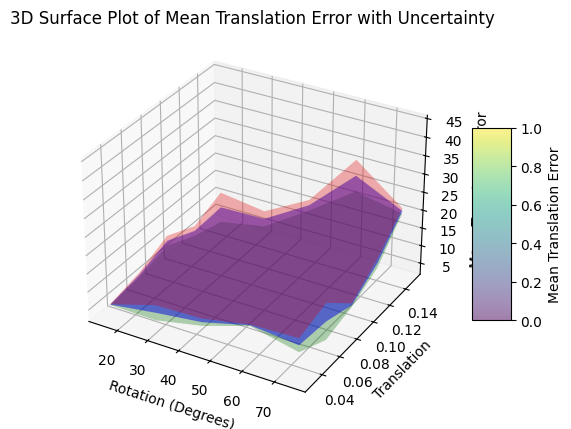

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to arrays for 3D plotting
X = np.array(pivot_df.columns)
Y = np.array(pivot_df.index)
X, Y = np.meshgrid(X, Y)
Z = pivot_df.values
Z_std = std_df.values

# Calculate surfaces for mean error ± standard deviation
Z_plus_std = Z + Z_std
Z_minus_std = Z - Z_std

# Plotting 3D Surface with Uncertainty
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the mean surface
surf_mean = ax.plot_surface(X, Y, Z, color='b', alpha=0.5, rstride=100, cstride=100, label='Mean Error')

# Plot the surface for mean error plus standard deviation
surf_plus_std = ax.plot_surface(X, Y, Z_plus_std, color='r', alpha=0.3, rstride=100, cstride=100, label='Mean Error + Std Dev')

# Plot the surface for mean error minus standard deviation
surf_minus_std = ax.plot_surface(X, Y, Z_minus_std, color='g', alpha=0.3, rstride=100, cstride=100, label='Mean Error - Std Dev')

# Add a color bar
fig.colorbar(surf_mean, ax=ax, shrink=0.5, aspect=5, label='Mean Translation Error')

# Labels and title
ax.set_xlabel('Rotation (Degrees)')
ax.set_ylabel('Translation')
ax.set_zlabel('Mean Translation Error')
ax.set_title('3D Surface Plot of Mean Translation Error with Uncertainty')

# Show plot
plt.show()

In [764]:
T_correct = []
for res in reses:
    T_0, T_1 = res.world_T_cam_b44[0], res.world_T_cam_b44[1]
    if np.allclose(T_1, np.eye(4)):
        T = T_0
    else:
        T = pose_inv(T_1)
    T_correct.append(T)


In [766]:
import numpy as np
from scipy.linalg import logm


def rotation_error(R1, R2):
    """Compute the angular error between two rotation matrices."""
    R = R1 @ R2.T
    theta = np.arccos((np.trace(R) - 1) / 2)
    return np.degrees(theta)


# Initialize error lists
errors_translation = []
errors_rotation = []

# Ground truth transformation matrix
gt_T = np.eye(4)
gt_T[:3, :3] = R_gt
gt_T[:3, 3] = t_gt

# Compute the errors
for T in T_correct:
    delta_T = gt_T @ pose_inv(T)
    
    # Translation error
    translation_error = np.linalg.norm(delta_T[:3, 3])
    errors_translation.append(translation_error)
    
    # Rotation error
    rotation_error_value = rotation_error(gt_T[:3, :3], T[:3, :3])
    errors_rotation.append(rotation_error_value)

# Print the mean and standard deviation of errors
print("dust3R translation:", np.mean(errors_translation), np.std(errors_translation))
print("dust3R rotation:", np.mean(errors_rotation), np.std(errors_rotation))

dust3R translation: 0.07811160463508447 0.007304454390056817
dust3R rotation: 16.77074641334625 1.049556534844623


In [767]:
errors = []
# Compute the angular error
for T in T_correct:
    errors.append(compute_translation_error(t_gt, T[:3, 3]))
print("dust3R translation:", np.mean(errors), np.std(errors))

errors = []
for T in T_correct:
    errors.append(angular_error(R_gt, T[:3, :3]))
print("dust3R rotation:", np.mean(errors), np.std(errors))

dust3R translation: 7.8394086240585175 4.962541191665082
dust3R rotation: 16.77074641334625 1.0495565348446225


In [ ]:
Image.open("experiments/scissor/demo_head_rgb.png")

In [ ]:
translation = {
    'x': [15, 30, 45, 60, 75],
    'Dust3R': {'y_mean': [12.023, 15, 13, 17, 20], 'y_std': [5.785, 2, 1.5, 2.5, 2]},
    'Method2': {'y_mean': [12, 14, 16, 19, 18], 'y_std': [1.2, 1.8, 1.4, 2.2, 1.8]},
    'Method3': {'y_mean': [9, 14, 12, 18, 21], 'y_std': [1.1, 2.1, 1.3, 2.4, 2.1]},
    'Method4': {'y_mean': [11, 13, 14, 16, 19], 'y_std': [0.9, 1.5, 1.2, 2.0, 1.7]},
    'Method5': {'y_mean': [13, 17, 15, 20, 22], 'y_std': [1.3, 2.3, 1.6, 2.7, 2.2]}
}

rotation = {
    'x': [15, 30, 45, 60, 75],
    'Dust3R': {'y_mean': [4.512, 16.771, 13, 17, 20], 'y_std': [0.683, 1.050,, 1.5, 2.5, 2]},
    'Method2': {'y_mean': [12, 14, 16, 19, 18], 'y_std': [1 1.8, 1.4, 2.2, 1.8]},
    'Method3': {'y_mean': [9, 14, 12, 18, 21], 'y_std': [1.1, 2.1, 1.3, 2.4, 2.1]},
    'Method4': {'y_mean': [11, 13, 14, 16, 19], 'y_std': [0.9, 1.5, 1.2, 2.0, 1.7]},
    'Method5': {'y_mean': [13, 17, 15, 20, 22], 'y_std': [1.3, 2.3, 1.6, 2.7, 2.2]}
}

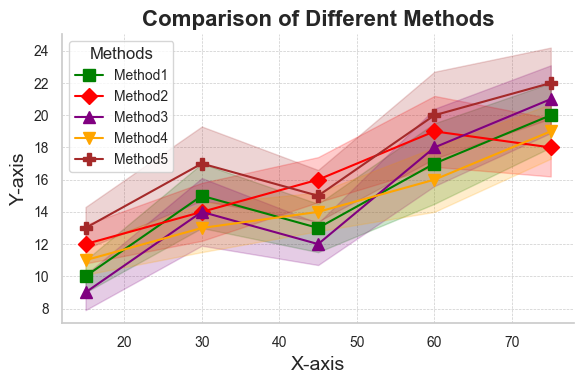

In [733]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data for multiple methods
data = {
    'x': [15, 30, 45, 60, 75],
    'Dust3R': {'y_mean': [12, 15, 13, 17, 20], 'y_std': [1, 2, 1.5, 2.5, 2]},
    'Method2': {'y_mean': [12, 14, 16, 19, 18], 'y_std': [1.2, 1.8, 1.4, 2.2, 1.8]},
    'Method3': {'y_mean': [9, 14, 12, 18, 21], 'y_std': [1.1, 2.1, 1.3, 2.4, 2.1]},
    'Method4': {'y_mean': [11, 13, 14, 16, 19], 'y_std': [0.9, 1.5, 1.2, 2.0, 1.7]},
    'Method5': {'y_mean': [13, 17, 15, 20, 22], 'y_std': [1.3, 2.3, 1.6, 2.7, 2.2]}
}

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(6, 4))

# Define colors and markers with enough elements
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'yellow', 'black']
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'd', 'p']

# Plot each method with shaded error regions
for i, (method, values) in enumerate(data.items()):
    if method != 'x':
        # Convert lists to numpy arrays for easier manipulation
        x = np.array(data['x'])
        y_mean = np.array(values['y_mean'])
        y_std = np.array(values['y_std'])

        plt.plot(x, y_mean, marker=markers[i], color=colors[i], markersize=8, label=method)
        plt.fill_between(x, y_mean - y_std, y_mean + y_std, color=colors[i], alpha=0.2)

# Customize the plot
plt.title('Comparison of Different Methods', fontsize=16, fontweight='bold')
plt.xlabel('X-axis', fontsize=14)
plt.ylabel('Y-axis', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Methods', fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove top and right spines
sns.despine()

# Display the plot
plt.tight_layout()
plt.show()

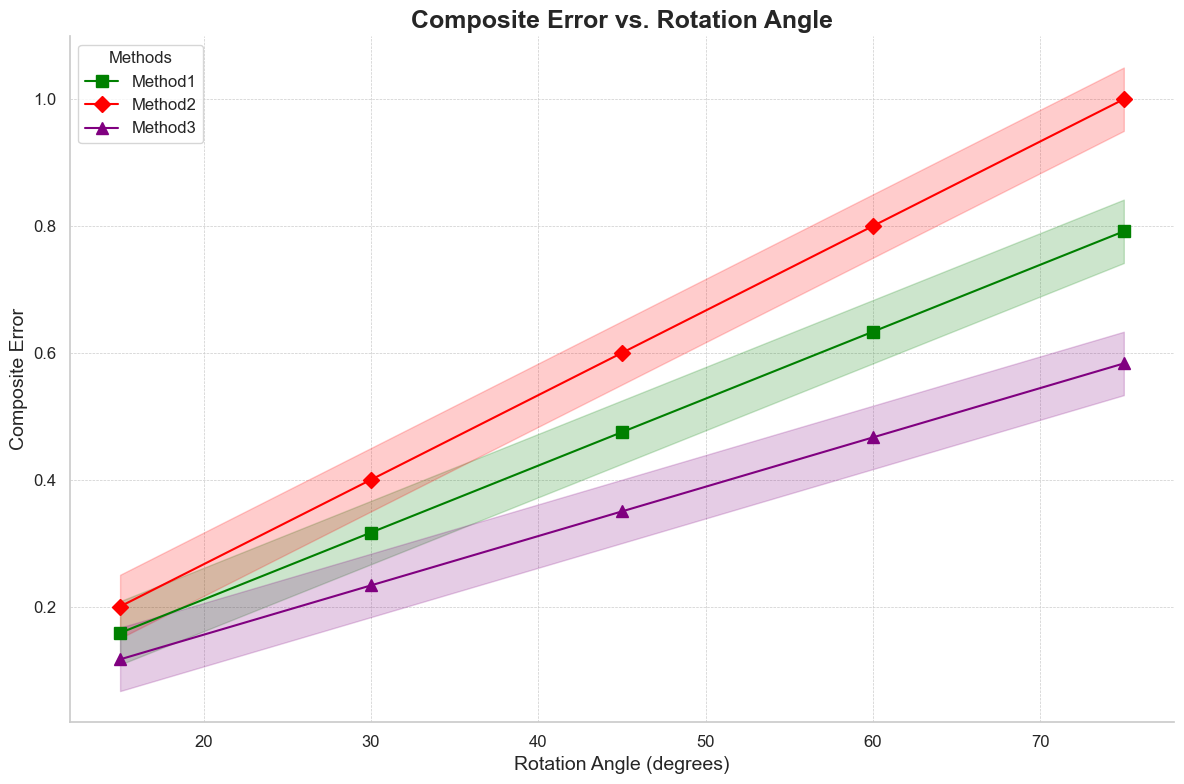

In [711]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example data for different methods
data = {
    'x': [15, 30, 45, 60, 75],  # Rotation angles
    'Method1': {'RTA': [5, 10, 15, 20, 25], 'RRA': [3, 6, 9, 12, 15]},
    'Method2': {'RTA': [6, 12, 18, 24, 30], 'RRA': [4, 8, 12, 16, 20]},
    'Method3': {'RTA': [4, 8, 12, 16, 20], 'RRA': [2, 4, 6, 8, 10]},
}

# Maximum possible values for normalization (assuming they are known or can be estimated)
max_RTA = 30
max_RRA = 20

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))

# Define colors and markers with enough elements
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'yellow', 'black']
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'd', 'p']

# Plot each method with shaded error regions
for i, (method, values) in enumerate(data.items()):
    if method != 'x':
        # Normalize the errors
        norm_RTA = np.array(values['RTA']) / max_RTA
        norm_RRA = np.array(values['RRA']) / max_RRA

        # Compute composite error (e.g., average of normalized RTA and RRA)
        composite_error = (norm_RTA + norm_RRA) / 2

        # Plot the composite error
        x = np.array(data['x'])
        plt.plot(x, composite_error, marker=markers[i], color=colors[i], markersize=8, label=method)
        plt.fill_between(x, composite_error - 0.05, composite_error + 0.05, color=colors[i], alpha=0.2)

# Customize the plot
plt.title('Composite Error vs. Rotation Angle', fontsize=18, fontweight='bold')
plt.xlabel('Rotation Angle (degrees)', fontsize=14)
plt.ylabel('Composite Error', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Methods', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove top and right spines
sns.despine()

# Display the plot
plt.tight_layout()
plt.show()



In [59]:
selected_numbers = random.sample(range(1, 51), 10)
selected_numbers

[30, 28, 17, 24, 15, 48, 13, 16, 19, 22]

In [53]:
import numpy as np
from scipy.spatial.transform import Rotation
from tqdm import tqdm
import pandas as pd
from trajectory_utils import pose_inv
from PIL import Image
from lightglue import LightGlue, SuperPoint, match_pair, SIFT
import torch
from camera_utils import d405_K as K

def numpy_image_to_torch(image: np.ndarray) -> torch.Tensor:
    """Normalize the image tensor and reorder the dimensions."""
    if image.ndim == 3:
        image = image.transpose((2, 0, 1))  # HxWxC to CxHxW
    elif image.ndim == 2:
        image = image[None]  # add channel axis
    else:
        raise ValueError(f"Not an image: {image.shape}")
    return torch.tensor(image / 255.0, dtype=torch.float, device="cpu")

def normalize_mkpts(mkpts, K):
    """
    Normalize image points using the camera intrinsic matrix.

    Args:
    mkpts: Nx2 numpy array of image points.
    K: 3x3 intrinsic matrix.

    Returns:
    normalized_points: Nx3 numpy array of normalized points in homogeneous coordinates.
    """
    # Convert points to homogeneous coordinates
    mkpts_h = np.hstack((mkpts, np.ones((mkpts.shape[0], 1))))

    # Compute the inverse of the intrinsic matrix
    K_inv = np.linalg.inv(K)

    # Normalize points
    normalized_points = (K_inv @ mkpts_h.T).T

    return normalized_points

def add_depth(mkpts, depth):
    points_3ds = []
    normalized_mkpts = normalize_mkpts(mkpts, K)
    for (i, mkpt) in enumerate(mkpts):
        x = int(mkpt[0])
        y = int(mkpt[1])
        points_3d = normalized_mkpts[i] * depth[y, x] / 1000
        points_3ds.append(points_3d)
    return np.array(points_3ds)


def find_transformation(X, Y):
    # Find transformation given two sets of correspondences between 3D points
    # Calculate centroids
    non_zero_indices = np.all(X != [0, 0, 0], axis=1) & np.all(Y != [0, 0, 0], axis=1)
    X = X[non_zero_indices]
    Y = Y[non_zero_indices]
    cX = np.mean(X, axis=0)
    cY = np.mean(Y, axis=0)
    # Subtract centroids to obtain centered sets of points
    Xc = X - cX
    Yc = Y - cY
    # Calculate covariance matrix
    C = np.dot(Xc.T, Yc)
    # Compute SVD
    U, S, Vt = np.linalg.svd(C)
    # Determine rotation matrix
    R = np.dot(Vt.T, U.T)
    # Determine translation vector
    t = cY - np.dot(R, cX)

    return R, t

def angular_error(R_gt, R_est):
    # Compute the relative rotation matrix
    R_rel = np.dot(R_gt.T, R_est)
    trace_R_rel = np.trace(R_rel)
    theta = np.arccos((trace_R_rel - 1) / 2)
    theta_deg = np.degrees(theta)
    
    return theta_deg


def compute_gt(gt_t, gt_rz):
    # Ground truth translation vector
    world_translation = np.array([gt_t, gt_t, gt_t])
    rotation = Rotation.from_euler('xyz', [0, 0, gt_rz], degrees=True)
    eef_translation = rotation.inv().apply(world_translation)
    t_gt = eef_translation @ np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])
    
    gt_T = np.eye(4)
    gt_T[:3, :3] = rotation.as_matrix()
    gt_T[:3, 3] = t_gt

    return gt_T

def match_mkpts_lightglue(t, r, k, filter_seg = False):
    cur_rgb_torch = numpy_image_to_torch(np.copy(Image.open(f"{dir}/t{t}_rot{r}/wrist_rgb_t{t}_rot{r}_{k+1}.png")))
    feats0, feats1, matches01 = match_pair(extractor, matcher, rgb_ref_torch, cur_rgb_torch)
    matches = matches01['matches']  # indices with shape (K,2)
    mkpts_0 = feats0['keypoints'][matches[..., 0]].cpu().numpy()  # coordinates in image #0, shape (K,2)
    mkpts_1 = feats1['keypoints'][matches[..., 1]].cpu().numpy()  # coordinates in image #1, shape (K,2)

    if filter_seg == False:
        return mkpts_0, mkpts_1
    else:
        coords = mkpts_0.astype(int)
        # Get the segment values for the corresponding coordinates
        seg_values = seg[coords[:, 1], coords[:, 0]]
        # Filter points where all segment values are True
        mask = np.all(seg_values, axis=1)
        filtered_mkpts_0 = mkpts_0[mask]
        filtered_mkpts_1 = mkpts_1[mask]

        return filtered_mkpts_0, filtered_mkpts_1

def solve_transform_3d(t, r, k, mkpts_0, mkpts_1):
    depth_cur = np.copy(Image.open(f"{dir}/t{t}_rot{r}/wrist_depth_t{t}_rot{r}_{k+1}.png"))
    points1_3d = add_depth(mkpts_0, depth_ref)
    points2_3d = add_depth(mkpts_1, depth_cur)
    delta_R_camera, delta_t_camera = find_transformation(points1_3d, points2_3d)
    T_est = np.eye(4)
    T_est[:3, :3] = delta_R_camera
    T_est[:3, 3] = delta_t_camera
    return T_est

def match_mkpts_xfeat(t, r, k, filter_seg = False):
    rgb_cur = np.copy(Image.open(f"{dir}/t{t}_rot{r}/wrist_rgb_t{t}_rot{r}_{k+1}.png"))
    mkpts_0, mkpts_1 = xfeat.match_xfeat_star(rgb_ref, rgb_cur, top_k = 2048)

    if filter_seg == False:
        return mkpts_0, mkpts_1
    else:
        coords = mkpts_0.astype(int)
        # Get the segment values for the corresponding coordinates
        seg_values = seg[coords[:, 1], coords[:, 0]]
        # Filter points where all segment values are True
        mask = np.all(seg_values, axis=1)
        filtered_mkpts_0 = mkpts_0[mask]
        filtered_mkpts_1 = mkpts_1[mask]

        return filtered_mkpts_0, filtered_mkpts_1
    
def solve_transform_dust3d(t, r, k):
    res = main([f"{dir}/wrist_rgb_ref.png", f"{dir}/t{t}_rot{r}/wrist_rgb_t{t}_rot{r}_{k+1}.png"])
    T_0, T_1 = res.world_T_cam_b44[0], res.world_T_cam_b44[1]
    if np.allclose(T_1, np.eye(4)):
        T = T_0
    else:
        T = pose_inv(T_1)
    return T

# Translations and rotations to test
# translations = [0, 0.03, 0.06, 0.09, 0.12, 0.15]
# rotations = [0, 15, 30, 45, 60, 75]
# dir = "dataset/scoop"
# dir = "dataset/sharpener"
# dir = "dataset/pan"

dirs = ["dataset/scoop", "dataset/sharpener", "dataset/pan"]
translations = [0]
rotations = [0]

# Initialize error lists
all_errors_translation = []
all_errors_rotation = []

# SuperPoint+LightGlue
extractor = SuperPoint(max_num_keypoints=2048).eval().cpu()  # load the extractor
matcher = LightGlue(features='superpoint', depth_confidence=-1, width_confidence=-1).eval().cpu()  # load the matcher

# Sift+LightGlue
# extractor = SIFT()
# matcher = LightGlue(features='sift', depth_confidence=-1, width_confidence=-1).eval().cpu()  # load the matcher

xfeat = torch.hub.load('verlab/accelerated_features', 'XFeat', pretrained = True, top_k = 2048)

df_translations = []
df_rotations = []

for dir in dirs:
    rgb_ref = np.array(Image.open(f"{dir}/wrist_rgb_ref.png"))
    depth_ref = np.copy(Image.open(f"{dir}/wrist_depth_ref.png"))
    seg = np.array(Image.open(f"{dir}/wrist_seg_ref.png")).astype(bool)
    # rgb_ref *= seg
    rgb_ref_torch = numpy_image_to_torch(rgb_ref)

    for i, t in enumerate(tqdm(translations, desc="Processing Translations", leave=False)):
        for j, r in enumerate(tqdm(rotations, desc=f"Processing Rotation for t={t}", leave=False)):
            gt_T = compute_gt(t, r)
            errors_translation = []
            errors_rotation = []
            for k in range(50):
                mkpts_0, mkpts_1 = match_mkpts_lightglue(t, r, k, filter_seg=True)
                # mkpts_0, mkpts_1 = match_mkpts_xfeat(t, r, k, filter_seg=False)
                if len(mkpts_0) == 0:
                    continue
                
                T_est = solve_transform_3d(t, r, k, mkpts_0, mkpts_1)
                delta_T = gt_T @ pose_inv(T_est)
            
                # Compute translation and rotation errors
                translation_error = np.linalg.norm(delta_T[:3, 3])
                errors_translation.append(translation_error)
                
                rotation_error_value = angular_error(gt_T[:3, :3], T_est[:3, :3])
                errors_rotation.append(rotation_error_value)
            
            if len(errors_translation) == 0:
                all_errors_translation.append((t, r, np.nan, np.nan))
                all_errors_rotation.append((t, r, np.nan, np.nan))
            else:
                all_errors_translation.append((t, r, np.mean(errors_translation), np.std(errors_translation)))
                all_errors_rotation.append((t, r, np.mean(errors_rotation), np.std(errors_rotation)))

    # Create dataframes for better readability
    df_translation = pd.DataFrame(all_errors_translation, columns=['Translation', 'Rotation', 'Mean Translation Error', 'STD Translation Error'])
    df_rotation = pd.DataFrame(all_errors_rotation, columns=['Translation', 'Rotation', 'Mean Rotation Error', 'STD Rotation Error'])
    df_translations.append(df_translation)
    df_rotations.append(df_rotation)

Using cache found in /Users/yilong/.cache/torch/hub/verlab_accelerated_features_main
Processing Translations:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
df_translations, df_rotation

([   Translation  Rotation  Mean Translation Error  STD Translation Error
  0            0         0                0.002727               0.001216,
     Translation  Rotation  Mean Translation Error  STD Translation Error
  0            0         0                0.002727               0.001216
  1            0         0                0.001849               0.000858,
     Translation  Rotation  Mean Translation Error  STD Translation Error
  0            0         0                0.002727               0.001216
  1            0         0                0.001849               0.000858
  2            0         0                0.033917               0.102239],
    Translation  Rotation  Mean Rotation Error  STD Rotation Error
 0            0         0             0.558332            0.256324
 1            0         0             0.438044            0.217562
 2            0         0             1.498765            3.985025)

In [44]:
df_translations, df_rotations

([   Translation  Rotation  Mean Translation Error  STD Translation Error
  0            0         0                0.009248               0.027216,
     Translation  Rotation  Mean Translation Error  STD Translation Error
  0            0         0                0.002217               0.001476,
     Translation  Rotation  Mean Translation Error  STD Translation Error
  0            0         0                0.004051               0.002141],
 [   Translation  Rotation  Mean Rotation Error  STD Rotation Error
  0            0         0             1.295371            4.157989,
     Translation  Rotation  Mean Rotation Error  STD Rotation Error
  0            0         0             0.595036            0.422499,
     Translation  Rotation  Mean Rotation Error  STD Rotation Error
  0            0         0             0.835589            0.453519])

In [217]:
res = {}
# Pivot the DataFrame
pivot_df = df_translation.pivot(index='Translation', columns='Rotation', values='Mean Translation Error').round(3)
# Adding standard deviation to the pivoted DataFrame
std_df = df_translation.pivot(index='Translation', columns='Rotation', values='STD Translation Error').round(3)
combined_df = pivot_df.astype(str) + ' ± ' + std_df.astype(str)

res["translation_mean"] = pivot_df
res["translation_std"] = std_df
combined_df

# # Pivot the DataFrame
# pivot_df = df_rotation.pivot(index='Translation', columns='Rotation', values='Mean Rotation Error').round(1)
# # Adding standard deviation to the pivoted DataFrame
# std_df = df_rotation.pivot(index='Translation', columns='Rotation', values='STD Rotation Error').round(1)
# combined_df = pivot_df.astype(str) + ' ± ' + std_df.astype(str)

# res["rotation_mean"] = pivot_df
# res["rotation_std"] = std_df
# combined_df

Rotation,0
Translation,
0,0.009 ± 0.006


In [219]:
res = {}
# Pivot the DataFrame
pivot_df = df_translation.pivot(index='Translation', columns='Rotation', values='Mean Translation Error').round(3)
# Adding standard deviation to the pivoted DataFrame
std_df = df_translation.pivot(index='Translation', columns='Rotation', values='STD Translation Error').round(3)
combined_df = pivot_df.astype(str) + ' ± ' + std_df.astype(str)

res["translation_mean"] = pivot_df
res["translation_std"] = std_df
combined_df

# Pivot the DataFrame
pivot_df = df_rotation.pivot(index='Translation', columns='Rotation', values='Mean Rotation Error').round(1)
# Adding standard deviation to the pivoted DataFrame
std_df = df_rotation.pivot(index='Translation', columns='Rotation', values='STD Rotation Error').round(1)
combined_df = pivot_df.astype(str) + ' ± ' + std_df.astype(str)

res["rotation_mean"] = pivot_df
res["rotation_std"] = std_df
combined_df

Rotation,0
Translation,
0,2.1 ± 1.3


In [209]:
0.004 ± 0.003, 1.2 ± 0.8
0.013 ± 0.006, 2.9 ± 1.4
0.009 ± 0.006, 2.1 ± 1.3

SyntaxError: invalid character '±' (U+00B1) (498836908.py, line 1)

In [196]:
3.3/3

1.0999999999999999

In [62]:
import pickle

# Save the object to a file
with open(f"{dir}/sift+lg_filter.pkl", 'wb') as file:
    res['ss_translation'] =  f"{res['translation_mean'][0][0]}±{res['translation_std'][0][0]}"
    res['ss_rotation'] =  f"{res['rotation_mean'][0][0]}±{res['rotation_std'][0][0]}"
    pickle.dump(res, file)

In [265]:
def compute_ACV(mean_df, std_df):
    return np.mean(mean_df / std_df).round(3)
    
# Load the object from the file
with open("dataset/sharpener/sp+lg.pkl", 'rb') as file:
    sp_lg = pickle.load(file)

with open("dataset/sharpener/sift+lg.pkl", 'rb') as file:
    sift_lg = pickle.load(file)

with open("dataset/sharpener/sift+lg_filter.pkl", 'rb') as file:
    sift_lg_filter = pickle.load(file)

with open("dataset/sharpener/sift+lg_masked.pkl", 'rb') as file:
    sift_lg_mask = pickle.load(file)

print("Translation ACV SP+LG:", compute_ACV(sp_lg['translation_mean'], sp_lg['translation_std']))
print("Translation ACV SIFT+LG:", compute_ACV(sift_lg['translation_mean'], sift_lg['translation_std']))
print("Translation ACV SIFT+LG Filter:", compute_ACV(sift_lg_filter['translation_mean'], sift_lg_filter['translation_std']))
print("Translation ACV SIFT+LG Masked:", compute_ACV(sift_lg_mask['translation_mean'], sift_lg_mask['translation_std']))


print("Translation ME SP+LG:", np.mean(sp_lg['translation_mean']).round(3), np.mean(sp_lg['translation_mean'].to_numpy()[:2, :3]).round(3))
print("Translation ME SIFT+LG:", np.mean(sift_lg['translation_mean']).round(3), str(np.nanmean(sift_lg['translation_mean'].to_numpy()[:2, :3]).round(3)) + "±" + str(np.nanmean(sift_lg['translation_std'].to_numpy()[:2, :3]).round(3)), "0.002±0.001")
print("Translation ME SIFT+LG Filter:", np.mean(sift_lg_filter['translation_mean']).round(3), str(np.nanmean(sift_lg_filter['translation_mean'].to_numpy()[:2, :3]).round(3)) + "±" + str(np.nanmean(sift_lg_filter['translation_std'].to_numpy()[:2, :3]).round(3)), "0.005±0.004")
print("Translation ME SIFT+LG Masked:", np.mean(sift_lg_mask['translation_mean']).round(3), str(np.nanmean(sift_lg_mask['translation_mean'].to_numpy()[:2, :3]).round(3)) + "±" + str(np.nanmean(sift_lg_mask['translation_std'].to_numpy()[:2, :3]).round(3)), "0.009±0.008")

# print("Rotation ACV SP+LG:", compute_ACV(sp_lg['rotation_mean'], sp_lg['rotation_std']))
print("Rotation ACV SIFT+LG:", compute_ACV(sift_lg['rotation_mean'], sift_lg['rotation_std']))
print("Rotation ACV SIFT+LG Filter:", compute_ACV(sift_lg_filter['rotation_mean'], sift_lg_filter['rotation_std']))
print("Rotation ACV SIFT+LG Masked:", compute_ACV(sift_lg_mask['rotation_mean'], sift_lg_mask['rotation_std']))

# print("Rotation ME SP+LG:", np.mean(sp_lg['rotation_mean']).round(3), np.mean(sp_lg['rotation_mean'].to_numpy()[:2, :2]).round(3))
print("Rotation ME SIFT+LG:", np.mean(sift_lg['rotation_mean']).round(3), np.mean(sift_lg['rotation_mean'].to_numpy()[:2, :2]).round(3), "0.6±0.4")
print("Rotation ME SIFT+LG Filter:", np.mean(sift_lg_filter['rotation_mean']).round(3), str(np.mean(sift_lg_filter['rotation_mean'].to_numpy()[:2, :3]).round(3)) + "±" + str(np.nanmean(sift_lg_filter['rotation_std'].to_numpy()[:2, :3].round(3))), "1.5±1.0")
print("Rotation ME SIFT+LG Masked:", np.mean(sift_lg_mask['rotation_mean']).round(3), str(np.nanmean(sift_lg_mask['rotation_mean'].to_numpy()[:2, :3]).round(3)) + "±" + str(np.nanmean(sift_lg_mask['rotation_std'].to_numpy()[:2, :3]).round(3)), "2.6±2.3")

Translation ACV SP+LG: 2.849
Translation ACV SIFT+LG: 1.567
Translation ACV SIFT+LG Filter: 1.884
Translation ACV SIFT+LG Masked: 1.357
Translation ME SP+LG: 0.286 0.075
Translation ME SIFT+LG: 0.259 0.035±0.026 0.002±0.001
Translation ME SIFT+LG Filter: 0.301 0.031±0.024 0.005±0.004
Translation ME SIFT+LG Masked: 0.301 0.125±0.134 0.009±0.008
Rotation ACV SIFT+LG: 1.349
Rotation ACV SIFT+LG Filter: 2.435
Rotation ACV SIFT+LG Masked: 1.736
Rotation ME SIFT+LG: 27.262 7.425 0.6±0.4
Rotation ME SIFT+LG Filter: 35.876 12.667±6.466666666666666 1.5±1.0
Rotation ME SIFT+LG Masked: 60.258 46.7±35.8 2.6±2.3


In [291]:
import pickle
import numpy as np
import pandas as pd

def compute_ACV(mean_df, std_df):
    acv = np.mean(std_df / mean_df).round(3)
    return acv

def load_data(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def compute_metrics(method_name, data):
    def get_metrics(mean_df, std_df):
        acv = compute_ACV(mean_df, std_df)
        mae = np.mean(mean_df).round(3)
        mae_block = np.nanmean(mean_df.to_numpy()[:2, :3]).round(3)
        std_block = np.nanmean(std_df.to_numpy()[:2, :3]).round(3)
        return acv, mae, f"{mae_block}±{std_block}"
    
    t_acv, t_mae, t_mae_close = get_metrics(data['translation_mean'], data['translation_std'])
    r_acv, r_mae, r_mae_close = get_metrics(data['rotation_mean'], data['rotation_std'])
    
    return {
        'method': method_name,
        'translation_ACV': t_acv,
        'rotation_ACV': r_acv,
        'translation_MAE': t_mae,
        'rotation_MAE': r_mae,
        'translation_MAE_close': t_mae_close,
        'rotation_MAE_close': r_mae_close,
        'ss_translation': data.get("ss_translation", " "),
        'ss_rotation': data.get("ss_rotation", " ")
    }

# File paths
file_paths = {
    'SP+LG Sharp': "dataset/sharpener/sp+lg.pkl",
    'SP+LG Pan': "dataset/pan/sp+lg.pkl",
    'SP+LG Scoop': "dataset/scoop/sp+lg.pkl",
    'SIFT+LG Sharp': "dataset/sharpener/sift+lg.pkl",
    'SIFT+LG Pan': "dataset/pan/sift+lg.pkl",
    'SIFT+LG Scoop': "dataset/scoop/sift+lg.pkl",
    # 'SIFT+LG Sharp Filter': "dataset/sharpener/sift+lg_filter.pkl",
    # 'SIFT+LG Pan Filter': "dataset/pan/sift+lg_filter.pkl",
    # 'SIFT+LG Sharp Mask': "dataset/sharpener/sift+lg_masked.pkl",
    # 'SIFT+LG Scoop Filter': "dataset/scoop/sift+lg_filter.pkl",
    'XFeat* Sharp': "dataset/sharpener/xfeat.pkl",
    'XFeat* Pan': "dataset/pan/xfeat.pkl",
    'XFeat* Scoop': "dataset/scoop/xfeat.pkl"
    # 'SP+LG-gim Sharp': "dataset/sharpener/sharpener_gim.pkl",
    # 'SP+LG-gim Pan': "dataset/sharpener/pan_gim.pkl",
    # 'SP+LG-gim Scoop': "dataset/sharpener/scoop_gim.pkl",

}

# Collect metrics for all methods
metrics_list = [compute_metrics(name, load_data(path)) for name, path in file_paths.items()]

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics_list)

metrics_df


,method,translation_ACV,rotation_ACV,translation_MAE,rotation_MAE,translation_MAE_close,rotation_MAE_close,ss_translation,ss_rotation
0,SP+LG Sharp,0.666,0.501,0.219,44.565,0.08±0.095,18.35±12.367,,
1,SP+LG Pan,0.968,0.892,0.288,32.905,0.076±0.09,6.15±7.767,,
2,SP+LG Scoop,0.515,0.533,0.268,16.350,0.034±0.01,6.233±2.85,,
3,SIFT+LG Sharp,0.801,0.853,0.259,27.262,0.035±0.026,9.1±10.283,,
4,SIFT+LG Pan,0.672,1.089,0.095,9.576,0.054±0.031,3.333±3.4,,
5,SIFT+LG Scoop,0.364,0.594,0.104,8.879,0.038±0.009,3.8±2.017,,
6,XFeat* Sharp,0.493,0.440,0.431,67.127,0.146±0.112,30.82±17.2,,
7,XFeat* Pan,0.921,0.866,0.554,56.143,0.101±0.153,23.483±25.7,,
8,XFeat* Scoop,0.550,0.563,0.408,64.783,0.14±0.092,26.317±14.833,,


In [296]:
np.split(metrics_df["translation_MAE_close"].to_numpy(), 3), np.split(metrics_df["rotation_MAE_close"].to_numpy(), 3)

([array(['0.08±0.095', '0.076±0.09', '0.034±0.01'], dtype=object),
  array(['0.035±0.026', '0.054±0.031', '0.038±0.009'], dtype=object),
  array(['0.146±0.112', '0.101±0.153', '0.14±0.092'], dtype=object)],
 [array(['18.35±12.367', '6.15±7.767', '6.233±2.85'], dtype=object),
  array(['9.1±10.283', '3.333±3.4', '3.8±2.017'], dtype=object),
  array(['30.82±17.2', '23.483±25.7', '26.317±14.833'], dtype=object)])

In [247]:
file_path = "dataset/sharpener/sift+lg.pkl"
data = load_data(file_path)
data 

{'translation_mean': Rotation        15     30     45     60     75
 Translation                                   
 0.03         0.019  0.037  0.045  0.073  0.165
 0.06         0.019  0.035  0.053  0.114  0.138
 0.09         0.062  0.085  0.151  0.246  0.263
 0.12         0.109  0.112  0.160  0.751  0.625
 0.15         0.245  0.209  0.758  0.906  1.097,
 'translation_std': Rotation        15     30     45     60     75
 Translation                                   
 0.03         0.007  0.026  0.021  0.047  0.136
 0.06         0.006  0.035  0.064  0.108  0.149
 0.09         0.103  0.107  0.212  0.222  0.217
 0.12         0.088  0.142  0.123  0.371  0.257
 0.15         0.157  0.173  0.422  0.351  0.289,
 'rotation_mean': Rotation       15    30    45    60    75
 Translation                              
 0.03          3.8  10.7  10.1  19.4  39.9
 0.06          5.1  10.1  14.8  26.8  34.6
 0.09         13.4  19.7  27.3  45.4  54.4
 0.12         20.7  21.5  32.4   NaN   NaN
 0.15       

In [273]:
file_path = "dataset/pan/xfeat.pkl"
data = load_data(file_path)
data 

{'translation_mean': Rotation        15     30     45     60     75
 Translation                                   
 0.03         0.075  0.142  0.071  0.753  0.396
 0.06         0.091  0.071  0.155  0.813  0.472
 0.09         0.110  0.222  1.419  0.862  0.369
 0.12         0.263  0.794  0.902  0.813  0.711
 0.15         0.583  0.674  1.023  1.113  0.947,
 'translation_std': Rotation        15     30     45     60     75
 Translation                                   
 0.03         0.139  0.201  0.138  0.370  0.478
 0.06         0.145  0.105  0.192  0.897  0.493
 0.09         0.211  0.218  0.891  0.725  0.236
 0.12         0.279  0.398  0.507  0.255  0.354
 0.15         0.305  0.329  0.422  0.203  0.094,
 'rotation_mean': Rotation       15     30     45    60    75
 Translation                                
 0.03          9.6   21.0   24.3  77.5  88.6
 0.06         19.3   19.4   47.3  94.4   NaN
 0.09         16.6   67.5  136.0   NaN   NaN
 0.12         46.9  117.6    NaN   NaN   NaN


In [239]:
print((14.6+10.1+14)/3, (11.2+15.3+9.2)/3)
print((8+7.6+3.4)/3, (9.5+9+1)/3)
print((3.5+5.4+3.8)/3, (2.6+3.1+0.9)/3)

print((30.82+23.483+26.317)/3, (17.2+25.7+14.833)/3)
print((18.35+6.15+6.233)/3, (12.367+7.767+2.85)/3)
print((9.1+3.333+3.8)/3, (10.283+3.4+2.017)/3)


12.9 11.9
6.333333333333333 6.5
4.233333333333333 2.2
26.873333333333335 19.244333333333334
10.244333333333334 7.661333333333334
5.4110000000000005 5.233333333333333


In [288]:
import pickle
import numpy as np
import pandas as pd

def compute_ACV(mean_df, std_df):
    acv = np.mean(std_df / mean_df).round(3)
    return acv

def load_data(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def compute_metrics(data):
    def get_metrics(mean_df, std_df):
        acv = compute_ACV(mean_df, std_df)
        mae = np.nanmean(mean_df).round(3)
        mae_block = np.nanmean(mean_df.to_numpy()[:2, :3]).round(3)
        std_block = np.nanmean(std_df.to_numpy()[:2, :3]).round(3)
        return acv, mae, f"{mae_block}±{std_block}"
    
    t_acv, t_mae, t_mae_close = get_metrics(data['translation_mean'], data['translation_std'])
    r_acv, r_mae, r_mae_close = get_metrics(data['rotation_mean'], data['rotation_std'])
    
    return {
        'translation_ACV': t_acv,
        'rotation_ACV': r_acv,
        'translation_MAE': t_mae,
        'rotation_MAE': r_mae,
        'translation_MAE_close': t_mae_close,
        'rotation_MAE_close': r_mae_close,
        'ss_translation': data.get("ss_translation", " "),
        'ss_rotation': data.get("ss_rotation", " ")
    }

# File paths
file_paths = {
    'SP+LG-gim Sharp': "dataset/sharpener/sharpener_gim.pkl",
    'SP+LG-gim Pan': "dataset/sharpener/pan_gim.pkl",
    'SP+LG-gim Scoop': "dataset/sharpener/scoop_gim.pkl",
    # 'SP+LG Sharp': "dataset/sharpener/sp+lg.pkl",
    # 'SP+LG Pan': "dataset/pan/sp+lg.pkl",
    # 'SP+LG Scoop': "dataset/scoop/sp+lg.pkl",
    # 'SIFT+LG Sharp': "dataset/sharpener/sift+lg.pkl",
    # 'SIFT+LG Pan': "dataset/pan/sift+lg.pkl",
    # 'SIFT+LG Scoop': "dataset/scoop/sift+lg.pkl",
    # 'XFeat* Sharp': "dataset/sharpener/xfeat.pkl",
    # 'XFeat* Pan': "dataset/pan/xfeat.pkl",
    # 'XFeat* Scoop': "dataset/scoop/xfeat.pkl"

}

# Initialize dictionaries to store aggregated data
agg_metrics = {
    'SP+LG': [],
    # 'SIFT+LG': [],
    # 'XFeat': []
}

# Process and aggregate metrics
for method_name, file_path in file_paths.items():
    data = load_data(file_path)
    metrics = compute_metrics(data)
    if 'SP+LG' in method_name:
        agg_metrics['SP+LG'].append(metrics)
    elif 'SIFT+LG' in method_name:
        agg_metrics['SIFT+LG'].append(metrics)
    elif 'XFeat' in method_name:
        agg_metrics['XFeat'].append(metrics)

# Compute average metrics for each category
def average_metrics(metrics_list):
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        if key.startswith('ss_'):
            avg_metrics[key] = " "
        else:
            values = [m[key] for m in metrics_list if isinstance(m[key], (int, float))]
            avg_metrics[key] = round(np.mean(values), 3)
    return avg_metrics

final_metrics = []
for method, metrics_list in agg_metrics.items():
    avg_metrics = average_metrics(metrics_list)
    avg_metrics['method'] = method
    final_metrics.append(avg_metrics)

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame(final_metrics)

metrics_df

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,translation_ACV,rotation_ACV,translation_MAE,rotation_MAE,translation_MAE_close,rotation_MAE_close,ss_translation,ss_rotation,method
0,1.108,1.209,0.249,27.132,NaN,NaN,,,SP+LG


In [263]:
0.612*0.153

0.093636

In [264]:
0.716*0.258

0.184728

In [290]:
# <!-- Translation ACV SP+LG: 2.849
# Translation ACV SIFT+LG: 1.567
# Translation ACV SIFT+LG Filter: 1.884
# Translation ACV SIFT+LG Masked: 1.357
# Translation ME SP+LG: 0.286 0.075
# Translation ME SIFT+LG: 0.259 0.035±0.026 0.002±0.001
# Translation ME SIFT+LG Filter: 0.301 0.031±0.024 0.005±0.004
# Translation ME SIFT+LG Masked: 0.301 0.125±0.134 0.009±0.008
# Rotation ACV SIFT+LG: 1.349
# Rotation ACV SIFT+LG Filter: 2.435
# Rotation ACV SIFT+LG Masked: 1.736
# Rotation ME SIFT+LG: 27.262 7.425 0.6±0.4
# Rotation ME SIFT+LG Filter: 35.876 12.667±6.466666666666666 1.5±1.0
# Rotation ME SIFT+LG Masked: 60.258 46.7±35.8 2.6±2.3 -->

file_path = "dataset/sharpener/sharpener_gim.pkl"
data = load_data(file_path)
data 

# # # Save the object to a file
# with open(file_path, 'wb') as file:
#     pickle.dump(data, file)
# data.get("ss_translation")
# data

{'translation_mean': Rotation        15     30     45     60     75
 Translation                                   
 0.03         0.049  0.055  0.063  0.093  0.267
 0.06         0.058  0.042  0.111  0.241  0.287
 0.09         0.367  0.239  0.274  0.359    NaN
 0.12         0.485  0.501  0.459    NaN    NaN
 0.15         0.406  0.530  0.543    NaN    NaN,
 'translation_std': Rotation        15     30     45     60     75
 Translation                                   
 0.03         0.085  0.074  0.077  0.107  0.250
 0.06         0.131  0.050  0.170  0.272  0.271
 0.09         0.341  0.311  0.319  0.326    NaN
 0.12         0.368  0.490  0.356    NaN    NaN
 0.15         0.386  0.352  0.428    NaN    NaN,
 'rotation_mean': Rotation       15    30    45    60    75
 Translation                              
 0.03          5.4   6.1   6.7   9.1  35.0
 0.06          7.6   4.5  12.0  29.2  36.3
 0.09         45.7  29.2  32.7  40.9  62.5
 0.12         55.4  51.1  50.4  63.6  66.7
 0.15       

In [285]:
data['rotation_std'] / data['rotation_mean']

Rotation,15,30,45,60,75
Translation,,,,,
0.03,0.727273,0.416667,0.120000,0.107143,0.200000
0.06,0.607143,0.361111,0.964286,0.172414,0.254545
0.09,0.551724,0.333333,0.192308,0.178571,1.788889
0.12,0.366667,0.238095,0.830769,1.885714,0.871528
0.15,0.285714,0.245283,1.613333,0.944086,NaN
